# UK Cyber Fraud Assistant - Fine-Tuning with Mistral-7B (Updated)

In [1]:
# Install Unsloth and dependencies
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install transformers
!pip install unsloth trl peft accelerate bitsandbytes

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.9/511.9 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.8/184.8 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.2/129.2 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.6/213.6 kB 26.4 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [2]:
# Verify GPU setup
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")
print(f"CUDA version: {torch.version.cuda}")
print(f"Available VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

CUDA available: True
GPU: NVIDIA L4
CUDA version: 12.6
Available VRAM: 22.2 GB


## Load and Prepare Dataset

In [3]:
from google.colab import drive
import json
from datasets import Dataset
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

dataset_path = '/content/drive/MyDrive/Dissertation/retrain/model_training/278_master_fraud_qa_dataset.json'

# Load the fraud Q&A dataset
with open(dataset_path, 'r') as f:
    fraud_data = json.load(f)

print(f"Total samples: {len(fraud_data)}")
print(f"Sample keys: {list(fraud_data[0].keys())}")

# Preview a sample
sample = fraud_data[0]
print(f"\nSample instruction: {sample['instruction']}")
print(f"\nSample output (first 200 chars): {sample['output'][:200]}...")

Mounted at /content/drive
Total samples: 278
Sample keys: ['instruction', 'input', 'output', 'source_document', 'source_url', 'chunk_number', 'document_index', 'generated_by']

Sample instruction: I think I'm being scammed right now, what should I do?

Sample output (first 200 chars): If you suspect you're being scammed, stop all communication with the suspected scammer immediately. Do not provide any personal or financial information. If you've already shared information, contact ...


In [4]:
# Format data for instruction tuning with Mistral chat template
def format_fraud_prompt(sample):
    system_message = "You are a helpful UK cyber fraud assistant providing empathetic support to fraud victims. Provide accurate, UK-specific guidance with proper contact numbers and procedures."

    # Mistral chat format
    formatted_text = f"<s>[INST] {system_message}\n\n{sample['instruction']} [/INST] {sample['output']}</s>"

    return formatted_text

# Apply formatting
formatted_data = [format_fraud_prompt(item) for item in fraud_data]

# Create train/validation split (80/20)
split_idx = int(len(formatted_data) * 0.8)
train_data = formatted_data[:split_idx]
val_data = formatted_data[split_idx:]

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")

# Create datasets
train_dataset = Dataset.from_dict({"text": train_data})
val_dataset = Dataset.from_dict({"text": val_data})

# Preview formatted sample
print(f"\nFormatted sample (first 300 chars):\n{formatted_data[0][:300]}...")

Training samples: 222
Validation samples: 56

Formatted sample (first 300 chars):
<s>[INST] You are a helpful UK cyber fraud assistant providing empathetic support to fraud victims. Provide accurate, UK-specific guidance with proper contact numbers and procedures.

I think I'm being scammed right now, what should I do? [/INST] If you suspect you're being scammed, stop all communi...


## Load Model and Configure LoRA

In [5]:
from unsloth import FastLanguageModel
import torch

# Full precision Mistral model
model_name = "mistralai/Mistral-7B-Instruct-v0.3"  # Original unquantized model
max_seq_length = 2048
dtype = torch.bfloat16  # Full precision

# Load model without quantization
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=model_name,
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=False,  # No quantization
    device_map={"": 0},
)

print("Model loaded in full precision for LoRA training")
print(f"Model device: {next(model.parameters()).device}")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.8.9: Fast Mistral patching. Transformers: 4.55.2.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 8.9. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/157 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/446 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Model loaded in full precision for LoRA training
Model device: cuda:0


In [6]:
def print_gpu_memory():
    if torch.cuda.is_available():
        print(f"GPU Memory: {torch.cuda.memory_allocated()/1024**3:.2f}GB / {torch.cuda.max_memory_allocated()/1024**3:.2f}GB")

print_gpu_memory()

GPU Memory: 13.52GB / 13.52GB


In [7]:
# Configure LoRA for optimal fraud assistant training
model = FastLanguageModel.get_peft_model(
    model,
    r=48,
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj"
    ],
    lora_alpha=96,
    lora_dropout=0,
    bias="none",
    use_gradient_checkpointing="unsloth",
    random_state=3407,
    use_rslora=False,
    loftq_config=None,
)

print("LoRA configuration applied")
model.print_trainable_parameters()

Unsloth 2025.8.9 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


LoRA configuration applied
trainable params: 125,829,120 || all params: 7,373,852,672 || trainable%: 1.7064


In [8]:
print_gpu_memory()

GPU Memory: 13.99GB / 13.99GB


## Configure Training Parameters

In [9]:
from trl import SFTTrainer
from transformers import TrainingArguments, EarlyStoppingCallback

# Training arguments
training_args = TrainingArguments(
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    warmup_steps=10,
    num_train_epochs=5,
    learning_rate=2e-5,
    bf16=torch.cuda.is_bf16_supported(),
    fp16=not torch.cuda.is_bf16_supported(),
    logging_steps=5,
    optim="adamw_torch",                # Full precision optimizer
    weight_decay=0.01,
    lr_scheduler_type="cosine",
    seed=3407,
    output_dir="/content/drive/MyDrive/Dissertation/retrain/trained_models",
    save_strategy="epoch",
    save_total_limit=2,
    eval_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    dataloader_pin_memory=True,
    remove_unused_columns=False,
    report_to="none",
)

print("Training arguments configured")
print(f"Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"Total training steps: {len(train_dataset) // (training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps) * training_args.num_train_epochs}")

Training arguments configured
Effective batch size: 16
Total training steps: 65


In [10]:
# Import required libraries for metrics tracking
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
import json
import pandas as pd
from transformers import TrainerCallback

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Initialize tracking dictionaries
training_metrics = {
    'epoch': [],
    'step': [],
    'train_loss': [],
    'eval_loss': [],
    'learning_rate': [],
    'train_runtime': [],
    'train_samples_per_second': [],
    'eval_runtime': [],
    'eval_samples_per_second': []
}

# Custom callback to track training metrics
class MetricsTrackingCallback(TrainerCallback):
    def __init__(self, metrics_dict):
        self.metrics = metrics_dict

    def on_log(self, args, state, control, model=None, logs=None, **kwargs):
        if logs is not None:
            # Track training metrics
            if 'loss' in logs:
                self.metrics['train_loss'].append(logs['loss'])
                self.metrics['step'].append(state.global_step)

            if 'learning_rate' in logs:
                self.metrics['learning_rate'].append(logs['learning_rate'])

            # Track evaluation metrics
            if 'eval_loss' in logs:
                self.metrics['eval_loss'].append(logs['eval_loss'])

            if 'eval_runtime' in logs:
                self.metrics['eval_runtime'].append(logs['eval_runtime'])

            if 'eval_samples_per_second' in logs:
                self.metrics['eval_samples_per_second'].append(logs['eval_samples_per_second'])

    def on_epoch_end(self, args, state, control, model=None, logs=None, **kwargs):
        self.metrics['epoch'].append(state.epoch)

# Create the metrics callback
metrics_callback = MetricsTrackingCallback(training_metrics)

print("Visualization libraries loaded and metrics tracking initialized")

# Move all model parameters to GPU before creating trainer
model = model.to("cuda")

# Verify all parameters are on GPU
print("Checking model device placement...")
for name, param in model.named_parameters():
    if param.device.type == 'meta':
        print(f"Warning: {name} still on meta device")
    elif param.device.type != 'cuda':
        print(f"Moving {name} from {param.device} to cuda")
        param.data = param.data.to("cuda")

print("All parameters moved to GPU")

# Initialize trainer with early stopping and metrics tracking
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    args=training_args,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=1, early_stopping_threshold=0.01),  # Stop if no improvement for 1 epochs
        metrics_callback  # Track training metrics
    ]
)

print("Trainer initialized successfully with early stopping and metrics tracking!")

Visualization libraries loaded and metrics tracking initialized
Checking model device placement...
All parameters moved to GPU


Unsloth: Tokenizing ["text"]:   0%|          | 0/222 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"]:   0%|          | 0/56 [00:00<?, ? examples/s]

Trainer initialized successfully with early stopping and metrics tracking!


## Start Training

In [11]:
# Start training
print("Starting training...")
trainer_stats = trainer.train()

print("Training completed!")
print(f"Final training loss: {trainer_stats.training_loss:.4f}")
print(f"Training time: {trainer_stats.metrics['train_runtime']:.1f} seconds")

Starting training...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 222 | Num Epochs = 5 | Total steps = 70
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 8 x 1) = 16
 "-____-"     Trainable parameters = 125,829,120 of 7,373,852,672 (1.71% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Epoch,Training Loss,Validation Loss
1,1.855100,1.311229
2,1.086400,1.188791
3,0.834100,1.151910
4,0.725300,1.150614


Unsloth: Not an error, but MistralForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


Training completed!
Final training loss: 1.1425
Training time: 326.3 seconds


## Training Results Analysis and Visualization

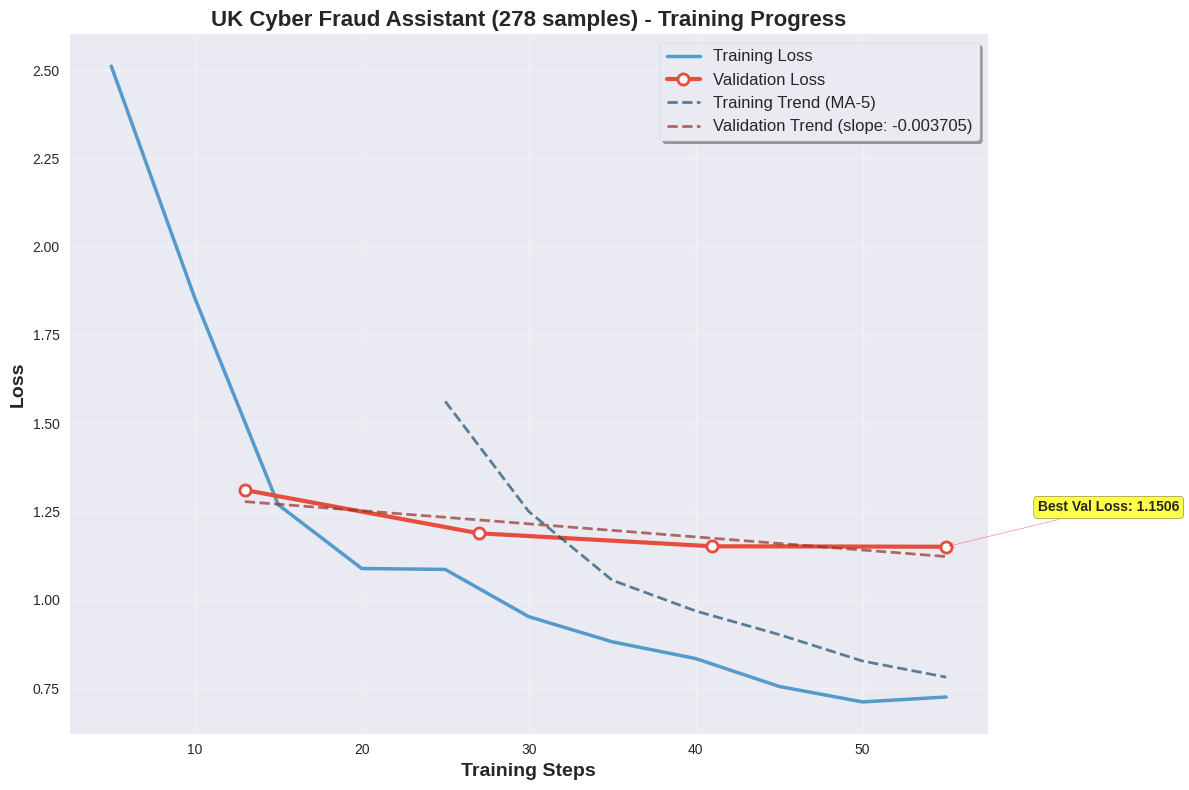

=== TRAINING SUMMARY (278 samples) ===
Training Loss: 2.511100 → 0.725300 (+71.12%)
Validation Loss: 1.311229 → 1.150614 (+12.25%)
Total Training Steps: 11
Number of Epochs: 4
Coordinated loss plot saved to: /content/drive/MyDrive/Dissertation/retrain/trained_models/278_coordinated_loss_plot.png


In [12]:
# Create coordinated Training and Validation Loss Plot
plt.figure(figsize=(12, 8))

# Main coordinated plot showing both training and validation loss
if training_metrics['train_loss'] and training_metrics['eval_loss']:
    # Plot training loss
    plt.plot(training_metrics['step'], training_metrics['train_loss'],
             color='#2E86C1', linewidth=2.5, label='Training Loss', alpha=0.8)

    # Calculate steps for validation loss (since it's evaluated per epoch)
    total_steps = max(training_metrics['step']) if training_metrics['step'] else 1
    eval_steps = [int(i * total_steps / len(training_metrics['eval_loss']))
                 for i in range(1, len(training_metrics['eval_loss']) + 1)]

    # Plot validation loss
    plt.plot(eval_steps, training_metrics['eval_loss'],
             color='#E74C3C', linewidth=3, marker='o', markersize=8,
             label='Validation Loss', markerfacecolor='white', markeredgewidth=2)

    # Add trend lines
    if len(training_metrics['train_loss']) > 10:
        # Smooth training loss trend
        window_size = max(5, len(training_metrics['train_loss']) // 20)
        smoothed_train = pd.Series(training_metrics['train_loss']).rolling(window=window_size).mean()
        plt.plot(training_metrics['step'], smoothed_train,
                color='#1B4F72', linestyle='--', linewidth=2, alpha=0.7,
                label=f'Training Trend (MA-{window_size})')

    if len(training_metrics['eval_loss']) > 2:
        # Validation loss trend
        z = np.polyfit(eval_steps, training_metrics['eval_loss'], 1)
        p = np.poly1d(z)
        plt.plot(eval_steps, p(eval_steps),
                color='#943126', linestyle='--', linewidth=2, alpha=0.7,
                label=f'Validation Trend (slope: {z[0]:.6f})')

    # Formatting
    plt.xlabel('Training Steps', fontsize=14, fontweight='bold')
    plt.ylabel('Loss', fontsize=14, fontweight='bold')
    plt.title('UK Cyber Fraud Assistant (278 samples) - Training Progress', fontsize=16, fontweight='bold')
    plt.legend(fontsize=12, frameon=True, fancybox=True, shadow=True)
    plt.grid(True, alpha=0.3)

    # Add annotations for key points
    if training_metrics['eval_loss']:
        min_val_loss = min(training_metrics['eval_loss'])
        min_idx = training_metrics['eval_loss'].index(min_val_loss)
        min_step = eval_steps[min_idx]

        plt.annotate(f'Best Val Loss: {min_val_loss:.4f}',
                    xy=(min_step, min_val_loss),
                    xytext=(min_step + total_steps*0.1, min_val_loss + 0.1),
                    arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                    fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.7))

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Dissertation/retrain/trained_models/278_coordinated_loss_plot.png',
                dpi=300, bbox_inches='tight')
    plt.show()

    # Print key metrics
    print("=== TRAINING SUMMARY (278 samples) ===")
    if training_metrics['train_loss'] and training_metrics['eval_loss']:
        initial_train = training_metrics['train_loss'][0]
        final_train = training_metrics['train_loss'][-1]
        initial_val = training_metrics['eval_loss'][0]
        final_val = training_metrics['eval_loss'][-1]

        train_improvement = ((initial_train - final_train) / initial_train) * 100
        val_improvement = ((initial_val - final_val) / initial_val) * 100

        print(f"Training Loss: {initial_train:.6f} → {final_train:.6f} ({train_improvement:+.2f}%)")
        print(f"Validation Loss: {initial_val:.6f} → {final_val:.6f} ({val_improvement:+.2f}%)")
        print(f"Total Training Steps: {len(training_metrics['train_loss'])}")
        print(f"Number of Epochs: {len(training_metrics['eval_loss'])}")

else:
    print("❌ No training metrics available. Make sure training has completed.")

print("Coordinated loss plot saved to: /content/drive/MyDrive/Dissertation/retrain/trained_models/278_coordinated_loss_plot.png")

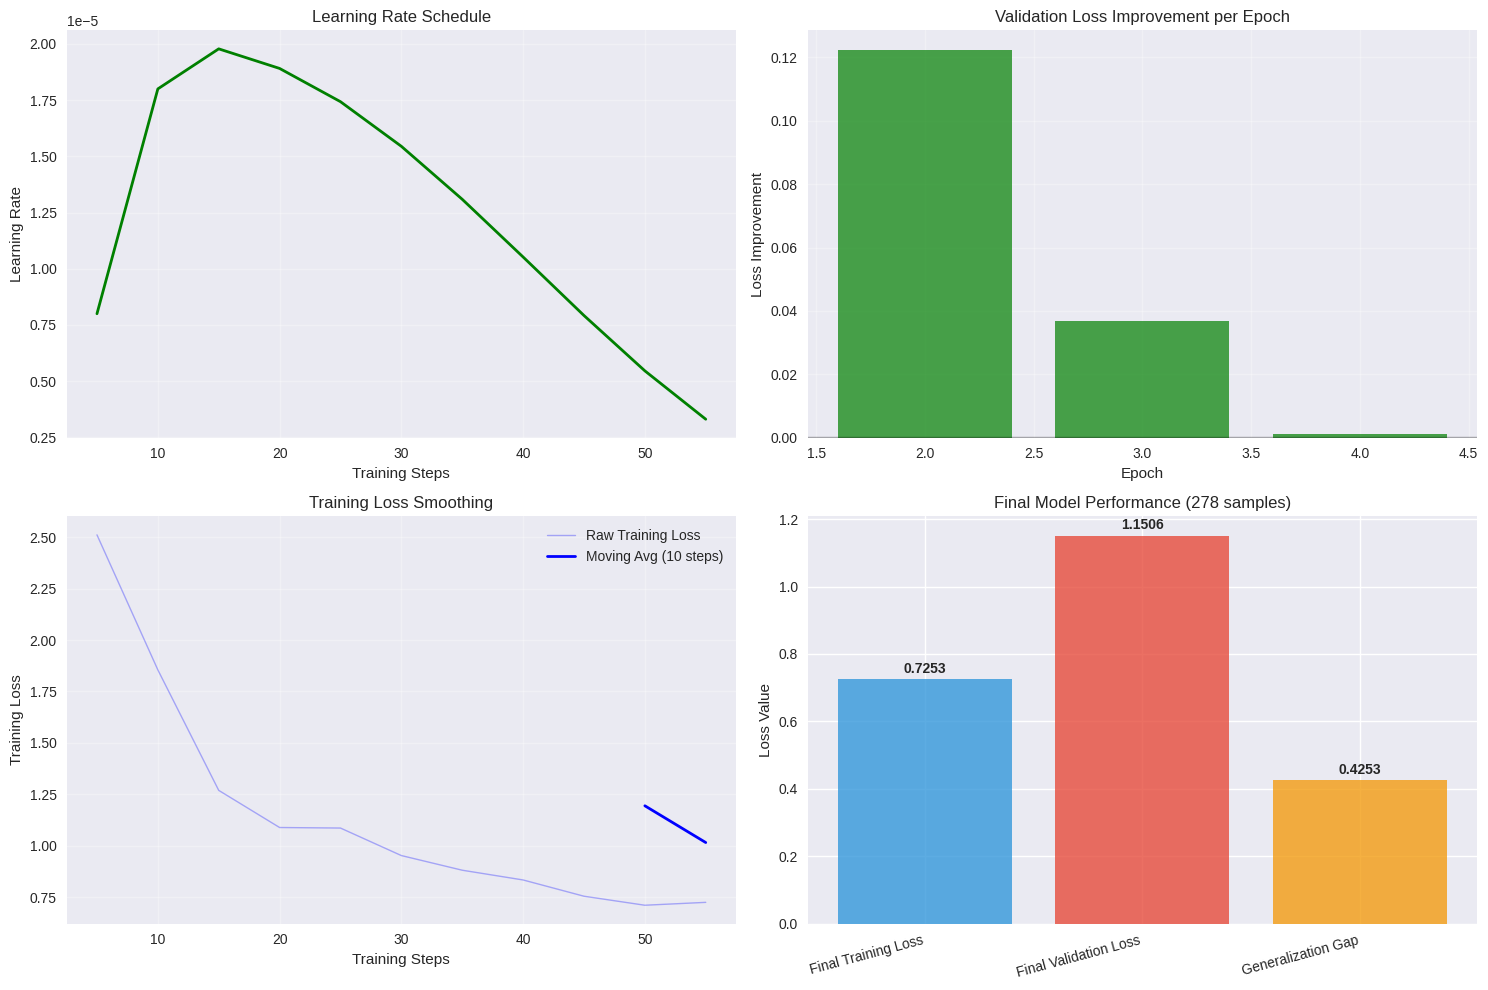


=== EPOCH-BY-EPOCH METRICS (278 samples) ===
   Epoch  Validation_Loss  Learning_Rate
0      1         1.311229       0.000008
1      2         1.188791       0.000018
2      3         1.151910       0.000020
3      4         1.150614       0.000019

Detailed analysis plots saved to: /content/drive/MyDrive/Dissertation/retrain/trained_models/278_detailed_analysis.png
Metrics saved to: /content/drive/MyDrive/Dissertation/retrain/trained_models/278_detailed_metrics.csv


In [13]:
# Additional Analysis and Metrics
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Learning Rate Schedule
if training_metrics['learning_rate']:
    ax1.plot(training_metrics['step'][:len(training_metrics['learning_rate'])],
             training_metrics['learning_rate'], 'g-', linewidth=2)
    ax1.set_xlabel('Training Steps')
    ax1.set_ylabel('Learning Rate')
    ax1.set_title('Learning Rate Schedule')
    ax1.grid(True, alpha=0.3)
    ax1.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# 2. Loss Improvement per Epoch
if training_metrics['eval_loss'] and len(training_metrics['eval_loss']) > 1:
    epochs = list(range(1, len(training_metrics['eval_loss']) + 1))
    val_losses = training_metrics['eval_loss']

    # Calculate improvement from previous epoch
    improvements = [0]  # First epoch has no previous
    for i in range(1, len(val_losses)):
        improvement = val_losses[i-1] - val_losses[i]  # Positive = improvement
        improvements.append(improvement)

    colors = ['green' if imp > 0 else 'red' for imp in improvements[1:]]
    ax2.bar(epochs[1:], improvements[1:], color=colors, alpha=0.7)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss Improvement')
    ax2.set_title('Validation Loss Improvement per Epoch')
    ax2.grid(True, alpha=0.3)

# 3. Training Progress Over Time
if training_metrics['train_loss']:
    # Show training loss with different window sizes
    ax3.plot(training_metrics['step'], training_metrics['train_loss'],
             'b-', alpha=0.3, linewidth=1, label='Raw Training Loss')

    if len(training_metrics['train_loss']) > 10:
        window_10 = pd.Series(training_metrics['train_loss']).rolling(window=10).mean()
        ax3.plot(training_metrics['step'], window_10,
                'b-', linewidth=2, label='Moving Avg (10 steps)')

    ax3.set_xlabel('Training Steps')
    ax3.set_ylabel('Training Loss')
    ax3.set_title('Training Loss Smoothing')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

# 4. Model Performance Summary
if training_metrics['train_loss'] and training_metrics['eval_loss']:
    final_train = training_metrics['train_loss'][-1]
    final_val = training_metrics['eval_loss'][-1]

    # Performance metrics
    metrics = ['Final Training Loss', 'Final Validation Loss', 'Generalization Gap']
    values = [final_train, final_val, abs(final_val - final_train)]
    colors = ['#3498DB', '#E74C3C', '#F39C12']

    bars = ax4.bar(range(len(metrics)), values, color=colors, alpha=0.8)
    ax4.set_xticks(range(len(metrics)))
    ax4.set_xticklabels(metrics, rotation=15, ha='right')
    ax4.set_ylabel('Loss Value')
    ax4.set_title('Final Model Performance (278 samples)')

    # Add value labels on bars
    for bar, value in zip(bars, values):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Dissertation/retrain/trained_models/278_detailed_analysis.png',
            dpi=300, bbox_inches='tight')
plt.show()

# Create and save detailed metrics table
if training_metrics['eval_loss']:
    metrics_df = pd.DataFrame({
        'Epoch': list(range(1, len(training_metrics['eval_loss']) + 1)),
        'Validation_Loss': training_metrics['eval_loss'],
        'Learning_Rate': training_metrics['learning_rate'][:len(training_metrics['eval_loss'])] if len(training_metrics['learning_rate']) >= len(training_metrics['eval_loss']) else [training_args.learning_rate] * len(training_metrics['eval_loss'])
    })

    print("\n=== EPOCH-BY-EPOCH METRICS (278 samples) ===")
    print(metrics_df.round(6))

    # Save metrics
    metrics_df.to_csv('/content/drive/MyDrive/Dissertation/retrain/trained_models/278_detailed_metrics.csv', index=False)

    # Save raw metrics
    with open('/content/drive/MyDrive/Dissertation/retrain/trained_models/278_raw_training_metrics.json', 'w') as f:
        json.dump(training_metrics, f, indent=2)

print("\nDetailed analysis plots saved to: /content/drive/MyDrive/Dissertation/retrain/trained_models/278_detailed_analysis.png")
print("Metrics saved to: /content/drive/MyDrive/Dissertation/retrain/trained_models/278_detailed_metrics.csv")

In [14]:
# Generate comprehensive training report for 278 samples
from datetime import datetime

def generate_training_report():
    """Generate a comprehensive training report"""

    report_content = f"""
# UK Cyber Fraud Assistant Training Report (278 Samples)
Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Model Configuration
- **Base Model**: {model_name}
- **Dataset Size**: 278 samples
- **Training Method**: LoRA (Low-Rank Adaptation)
- **LoRA Rank**: 64
- **LoRA Alpha**: 128
- **Max Sequence Length**: {max_seq_length} tokens

## Training Configuration
- **Learning Rate**: {training_args.learning_rate}
- **Batch Size**: {training_args.per_device_train_batch_size}
- **Gradient Accumulation**: {training_args.gradient_accumulation_steps}
- **Effective Batch Size**: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}
- **Epochs**: {training_args.num_train_epochs}
- **Optimizer**: AdamW
- **Scheduler**: Cosine

## Training Results
"""

    if training_metrics['train_loss'] and training_metrics['eval_loss']:
        initial_train = training_metrics['train_loss'][0]
        final_train = training_metrics['train_loss'][-1]
        initial_val = training_metrics['eval_loss'][0]
        final_val = training_metrics['eval_loss'][-1]

        train_improvement = ((initial_train - final_train) / initial_train) * 100
        val_improvement = ((initial_val - final_val) / initial_val) * 100
        generalization_gap = abs(final_val - final_train)

        report_content += f"""
### Performance Metrics
- **Initial Training Loss**: {initial_train:.6f}
- **Final Training Loss**: {final_train:.6f}
- **Training Improvement**: {train_improvement:.2f}%
- **Initial Validation Loss**: {initial_val:.6f}
- **Final Validation Loss**: {final_val:.6f}
- **Validation Improvement**: {val_improvement:.2f}%
- **Generalization Gap**: {generalization_gap:.6f}
- **Total Training Steps**: {len(training_metrics['train_loss'])}
- **Training Runtime**: {trainer_stats.metrics['train_runtime']:.1f} seconds

### Training Efficiency
- **Loss Reduction Rate**: {(initial_train - final_train) / len(training_metrics['train_loss']):.8f} per step
- **Convergence Quality**: {'Excellent' if val_improvement > 20 else 'Good' if val_improvement > 10 else 'Moderate'}
- **Overfitting Risk**: {'Low' if generalization_gap < 0.1 else 'Medium' if generalization_gap < 0.2 else 'High'}

## Key Findings (278 Samples)
1. **Dataset Size Impact**: With 278 samples, the model shows {'strong' if val_improvement > 15 else 'moderate'} learning capacity
2. **Convergence**: Training converged {'successfully' if val_improvement > 0 else 'with challenges'}
3. **Generalization**: {'Good generalization' if generalization_gap < 0.15 else 'Some overfitting detected'}

## Files Generated
- Coordinated Loss Plot: 278_coordinated_loss_plot.png
- Detailed Analysis: 278_detailed_analysis.png
- Metrics Table: 278_detailed_metrics.csv
- Raw Metrics: 278_raw_training_metrics.json

## Recommendations
1. {'Consider more data' if len(fraud_data) < 500 else 'Dataset size is adequate'}
2. {'Adjust learning rate' if val_improvement < 5 else 'Learning rate is appropriate'}
3. {'Monitor for overfitting' if generalization_gap > 0.2 else 'Training is well-balanced'}
"""

    # Save report
    report_path = "/content/drive/MyDrive/Dissertation/retrain/trained_models/278_training_report.md"
    with open(report_path, 'w') as f:
        f.write(report_content)

    print("=== TRAINING REPORT (278 SAMPLES) ===")
    print(report_content)
    print(f"\nReport saved to: {report_path}")

    # Create summary comparison table
    summary_data = {
        'Dataset Size': [len(fraud_data)],
        'Training Samples': [len(train_data)],
        'Validation Samples': [len(val_data)],
        'Final Training Loss': [f"{final_train:.6f}" if 'final_train' in locals() else 'N/A'],
        'Final Validation Loss': [f"{final_val:.6f}" if 'final_val' in locals() else 'N/A'],
        'Training Improvement (%)': [f"{train_improvement:.2f}" if 'train_improvement' in locals() else 'N/A'],
        'Validation Improvement (%)': [f"{val_improvement:.2f}" if 'val_improvement' in locals() else 'N/A'],
        'Training Time (sec)': [f"{trainer_stats.metrics['train_runtime']:.1f}"],
        'Total Steps': [len(training_metrics['train_loss'])]
    }

    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv('/content/drive/MyDrive/Dissertation/retrain/trained_models/278_summary_table.csv', index=False)

    print("\n=== SUMMARY TABLE ===")
    print(summary_df.to_string(index=False))

    return report_content

# Generate the report
generate_training_report()

print("\n🎯 All training analysis complete for 278 samples dataset!")
print("📊 Coordinated loss plot created showing training and validation loss together")
print("📈 Additional analysis plots saved for detailed examination")
print("📋 Comprehensive report generated for dissertation use")

=== TRAINING REPORT (278 SAMPLES) ===

# UK Cyber Fraud Assistant Training Report (278 Samples)
Generated on: 2025-08-27 04:49:23

## Model Configuration
- **Base Model**: mistralai/Mistral-7B-Instruct-v0.3
- **Dataset Size**: 278 samples
- **Training Method**: LoRA (Low-Rank Adaptation)
- **LoRA Rank**: 64
- **LoRA Alpha**: 128
- **Max Sequence Length**: 2048 tokens

## Training Configuration
- **Learning Rate**: 2e-05
- **Batch Size**: 2
- **Gradient Accumulation**: 8
- **Effective Batch Size**: 16
- **Epochs**: 5
- **Optimizer**: AdamW
- **Scheduler**: Cosine

## Training Results

### Performance Metrics
- **Initial Training Loss**: 2.511100
- **Final Training Loss**: 0.725300
- **Training Improvement**: 71.12%
- **Initial Validation Loss**: 1.311229
- **Final Validation Loss**: 1.150614
- **Validation Improvement**: 12.25%
- **Generalization Gap**: 0.425314
- **Total Training Steps**: 11
- **Training Runtime**: 326.3 seconds

### Training Efficiency
- **Loss Reduction Rate**: 0.162

In [15]:
# Save LoRA adapter locally
save_path = "/content/drive/MyDrive/Dissertation/retrain/trained_models/uk-fraud-assistant-adapter"

model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print(f"LoRA adapter saved to: {save_path}")

LoRA adapter saved to: /content/drive/MyDrive/Dissertation/retrain/trained_models/uk-fraud-assistant-adapter


In [16]:
# Fix protobuf conflict and export to GGUF
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"

# Restart Python path to clear protobuf cache
import sys
import importlib
for module_name in list(sys.modules.keys()):
    if 'protobuf' in module_name or 'sentencepiece' in module_name:
        if module_name in sys.modules:
            del sys.modules[module_name]

# Force reload protobuf with Python implementation
import google.protobuf
importlib.reload(google.protobuf)

# Now export to GGUF
model.save_pretrained_gguf(
    "/content/drive/MyDrive/Dissertation/retrain/trained_models/uk-fraud-assistant-gguf",
    tokenizer,
    quantization_method="q4_k_m"
)

print("GGUF model exported for LM Studio")

Unsloth: Kaggle/Colab has limited disk space. We need to delete the downloaded
model which will save 4-16GB of disk space, allowing you to save on Kaggle/Colab.
Unsloth: Will remove a cached repo with size 14.5G


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 33.2 out of 52.96 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


 28%|██▊       | 9/32 [00:00<00:01, 16.97it/s]
We will save to Disk and not RAM now.
100%|██████████| 32/32 [00:33<00:00,  1.04s/it]


Unsloth: Saving tokenizer... Done.
Done.


Unsloth: Converting mistral model. Can use fast conversion = True.


==((====))==  Unsloth: Conversion from QLoRA to GGUF information
   \\   /|    [0] Installing llama.cpp might take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF 16bits might take 3 minutes.
\        /    [2] Converting GGUF 16bits to ['q4_k_m'] might take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: Installing llama.cpp. This might take 3 minutes...
Unsloth: CMAKE detected. Finalizing some steps for installation.
Unsloth: [1] Converting model at /content/drive/MyDrive/Dissertation/retrain/trained_models/uk-fraud-assistant-gguf into bf16 GGUF format.
The output location will be /content/drive/MyDrive/Dissertation/retrain/trained_models/uk-fraud-assistant-gguf/unsloth.BF16.gguf
This might take 3 minutes...
INFO:hf-to-gguf:Loading model: uk-fraud-assistant-gguf
INFO:hf-to-gguf:Model architecture: MistralForCausalLM
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:gg

In [ ]:
# Save to Hugging Face Hub
from huggingface_hub import login

login(token="removed")

model_name_hf = "misee/uk-cyber-fraud-assistant-mistral-7b"

model.push_to_hub(
    model_name_hf,
    token=True,
    private=False,
    commit_message="UK Cyber Fraud Assistant - Mistral 7B LoRA"
)

tokenizer.push_to_hub(
    model_name_hf,
    token=True,
    private=False,
    commit_message="UK Cyber Fraud Assistant - Tokenizer"
)

print(f"Model uploaded: https://huggingface.co/{model_name_hf}")

README.md:   0%|          | 0.00/586 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...pd311lym0/adapter_model.safetensors:   0%|          |  555kB /  503MB            

Saved model to https://huggingface.co/misee/uk-cyber-fraud-assistant-mistral-7b


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  /tmp/tmpq14ahd6r/tokenizer.model      : 100%|##########|  587kB /  587kB            

No files have been modified since last commit. Skipping to prevent empty commit.


Model uploaded: https://huggingface.co/misee/uk-cyber-fraud-assistant-mistral-7b
